## Setup

In [1]:
import pandas as pd
import numpy as np
import os
np.random.seed(24)

In [2]:
housing = pd.read_csv("datasets/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Data Split by stratification

In [3]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print("Train set:", strat_train_set.shape)
print("Test set:", strat_test_set.shape)

Train set: (16512, 11)
Test set: (4128, 11)


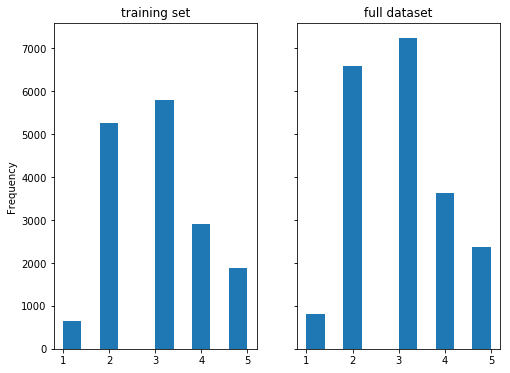

In [5]:
# %matplotlib inline
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2,sharey=True,figsize=(8,6))
# ax[0].hist(strat_train_set["income_cat"])
# ax[0].set_title("training set")
# ax[1].hist(housing["income_cat"])
# ax[1].set_title("full set")
strat_train_set["income_cat"].plot(kind="hist", ax=ax[0], title="training set")
housing["income_cat"].plot(kind="hist", ax=ax[1], title="full dataset")
plt.show()

In [6]:
strat_train_set.drop(["income_cat"], axis=1, inplace=True)

In [7]:
strat_train_set.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN


#### Data Preparation
* For numerical attributes, fill in missing data, standardization, add additional attribute
* For categorical attributes, apply one-hot-encoder

In [8]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_label = strat_train_set["median_house_value"].copy()
print(housing.head(2), "\n")
print(housing_label.head(2))

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   

       population  households  median_income ocean_proximity  
17606       710.0       339.0         2.7042       <1H OCEAN  
18632       306.0       113.0         6.4214       <1H OCEAN   

17606    286600.0
18632    340600.0
Name: median_house_value, dtype: float64


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return LabelBinarizer().fit(X).transform(X)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = True
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, rooms_ix]/X[:, household_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [11]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self # do nothing
    def transform(self, X, y=None):
        return X[self.attribute_names].values # return numpy array

In [12]:
num_attribs = housing.columns.values.tolist()
num_attribs.remove("ocean_proximity")
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [13]:
cat_attribs = ["ocean_proximity"]

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)), # select numeric columns
        ('imputer', Imputer(strategy="median")), # fill missing values with median
        ('attribs_adder', CombinedAttributesAdder()), # add extra columns
        ('std_scaler', StandardScaler()), # standardize
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),  # select categorical columns
        ('label_binarizer', CustomBinarizer()), # binarize categorical attributes
    ])


In [15]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [16]:
housing_pred = full_pipeline.fit_transform(housing)

In [17]:
housing_pred

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [18]:
housing_pred.shape

(16512, 16)

## Practice

### Question 1

Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
param_grid = [{"kernel": ["linear"], "C": [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
              {"kernel": ["rbf"], "C": [1.0, 3.0, 10., 30., 100., 300., 1000.0], 
              "gamma": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}]
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=4)
grid_search.fit(housing_pred, housing_label)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 32.7min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 54.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [20]:
grid_search.best_estimator_

SVR(C=30000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [21]:
negative_mse = grid_search.best_score_
print(np.sqrt(-negative_mse))

70355.0440319


In [22]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

### Question 2 

Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [24]:
from sklearn.model_selection import RandomizedSearchCV
param_hist ={"kernel": ["linear", "rbf"], "C": np.linspace(1.0, 400.0, 10), "gamma": np.linspace(0.1, 3.0,10)}
svm_reg = SVR()
rnd_search = RandomizedSearchCV(estimator=svm_reg, cv=5, param_distributions=param_hist, 
                                n_jobs=4, scoring="neg_mean_squared_error", verbose=4)

In [25]:
rnd_search.fit(housing_pred, housing_label)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  7.4min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': array([   1.     ,   45.33333,   89.66667,  134.     ,  178.33333,
        222.66667,  267.     ,  311.33333,  355.66667,  400.     ]), 'gamma': array([ 0.1    ,  0.42222,  0.74444,  1.06667,  1.38889,  1.71111,
        2.03333,  2.35556,  2.67778,  3.     ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=4)

In [28]:
rnd_search.best_estimator_

SVR(C=355.66666666666669, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.10000000000000001, kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
rmse =np.sqrt(-rnd_search.best_score_)
rmse

70776.05232362407

In [30]:
rnd_search.best_params_

{'C': 355.66666666666669, 'gamma': 0.10000000000000001, 'kernel': 'linear'}

### Question 3 

Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
param_hist = {"n_estimators": np.arange(10, 500, 20),
             "max_depth": np.arange(5, 50, 5),
             "max_features": [2,4,6,8]}
rnd_search = RandomizedSearchCV(estimator=forest_reg, cv=5, param_distributions=param_hist,
                                scoring="neg_mean_squared_error",
                                n_jobs=4,verbose=4)

In [32]:
rnd_search.fit(housing_pred, housing_label)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   51.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490]), 'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]), 'max_features': [2, 4, 6, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=4)

In [33]:
cvre = rnd_search.cv_results_
for mean_score, params in zip(cvre["mean_test_score"], cvre["params"]):
    print(np.sqrt(-mean_score), params)

52060.2555696 {'n_estimators': 450, 'max_features': 2, 'max_depth': 20}
49238.8756776 {'n_estimators': 130, 'max_features': 6, 'max_depth': 45}
66101.4402236 {'n_estimators': 10, 'max_features': 4, 'max_depth': 5}
49751.1531955 {'n_estimators': 150, 'max_features': 4, 'max_depth': 30}
63881.9421156 {'n_estimators': 230, 'max_features': 6, 'max_depth': 5}
49686.9217466 {'n_estimators': 370, 'max_features': 4, 'max_depth': 45}
49245.6635681 {'n_estimators': 50, 'max_features': 8, 'max_depth': 45}
49111.4635648 {'n_estimators': 150, 'max_features': 8, 'max_depth': 45}
49029.9589565 {'n_estimators': 250, 'max_features': 8, 'max_depth': 25}
48975.3607899 {'n_estimators': 450, 'max_features': 6, 'max_depth': 25}


In [34]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [35]:
feature_importances = rnd_search.best_estimator_.feature_importances_
extra_attribs = ["room_per_household", "pop_per_household", "bedroom_per_room"]
encoder = LabelBinarizer()
housing_cat_encoded = encoder.fit_transform(housing["ocean_proximity"])
cat_attribs = encoder.classes_.tolist()
attribs = num_attribs + extra_attribs + cat_attribs
sorted(zip(feature_importances, attribs))

[(9.009785961144755e-05, 'ISLAND'),
 (0.0036536425199274977, 'NEAR BAY'),
 (0.0058115751541513759, 'NEAR OCEAN'),
 (0.012801894036169643, '<1H OCEAN'),
 (0.016703575905991436, 'households'),
 (0.017637018284687816, 'total_bedrooms'),
 (0.018150443059985907, 'population'),
 (0.018200907902330324, 'total_rooms'),
 (0.042705559821710801, 'housing_median_age'),
 (0.059257344789281317, 'bedroom_per_room'),
 (0.060449404612828009, 'room_per_household'),
 (0.075023544690905358, 'latitude'),
 (0.079813372456403062, 'longitude'),
 (0.10827407602322664, 'pop_per_household'),
 (0.15239500049196869, 'INLAND'),
 (0.32903254239082108, 'median_income')]

In [36]:
# pick the feature of important
from sklearn.base import BaseEstimator, TransformerMixin
def indices_of_top_k(arr, k):
    return(np.sort(np.argpartition(np.array(arr), -k)[-k:]))
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importance, k):
        self.feature_importance = feature_importance
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importance, self.k)
        return self
    def transform(self, X, y=None):
        return(X[:, self.feature_indices_])

In [37]:
indices_of_top_k(feature_importances, 5) # the top five important features

array([ 0,  1,  7,  9, 12], dtype=int64)

In [38]:
np.array(attribs)[indices_of_top_k(feature_importances, 5)]

array(['longitude', 'latitude', 'median_income', 'pop_per_household',
       'INLAND'], 
      dtype='<U18')

In [39]:
preparation_and_feature_selection_pipeline = Pipeline([
    ("preparation", full_pipeline),
    ("feature_selection", TopFeatureSelector(feature_importances, 5))])
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)
housing_prepared_top_k_features[:3,:]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [40]:
from sklearn.model_selection import cross_val_score
rnd_reg=RandomForestRegressor(max_features=8, n_estimators=30)
scores = cross_val_score(rnd_reg, X=housing_pred, y=housing_label, 
                           scoring="neg_mean_squared_error", cv=5, 
                           n_jobs=-1,verbose=4)
rmse = [np.sqrt(-i) for i in scores]
print(rmse)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s


[48191.050872522581, 50738.757974224805, 51552.653141120863, 48638.154626029522, 51066.660103349139]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


In [41]:
# using n_estimator = 350
rnd_reg = RandomForestRegressor(max_features=8, n_estimators=350)
scores = cross_val_score(estimator=rnd_reg, cv=5, X=housing_pred, y=housing_label, 
                        scoring="neg_mean_squared_error", n_jobs=-1, verbose=4)
rmse = [np.sqrt(-i) for i in scores]
print(rmse)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.0s remaining:  1.1min


[47561.770428136617, 49734.712059204707, 50344.797358748678, 47284.795982948941, 50155.38573874475]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


### Question 4

Try creating a single pipeline that does the full data preparation plus the final prediction.

In [74]:
prepare_prediction_pipeline = Pipeline([
    ("preparation", full_pipeline),
    ("feature_selection", TopFeatureSelector(feature_importances, 6)), 
    ("prediction", rnd_search.best_estimator_)
])

In [75]:
some_data = housing.iloc[:4]
some_data_label = housing_label[:4]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND


In [76]:
prepare_prediction_pipeline.fit(some_data, some_data_label)

Pipeline(steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('imputer', Imputer(...stimators=450, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [79]:
print("Label", some_data_label.values)
print("Prediction", prepare_prediction_pipeline.predict(some_data))      

Label [ 286600.  340600.  196900.   46300.]
Prediction [ 273038.66666667  296892.66666667  202522.66666667  138553.33333333]


### Question 5

Automatically explore some preparation options using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [4, 5, 6]}
]

grid_search_prep = GridSearchCV(preparation_and_feature_selection_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=4, n_jobs=-1)
grid_search_prep.fit(housing, housing_label)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
